# Shapelet based time series machine learning

In this notebook, our goal is to introduce the notions necessary to understand the use of Shapelets for time series machine learning. We provide both  theoritical knowledge, through formal definitions and references, and practical knowledge, to show how these theoritical concepts are used into the shapelet-based estimators available in `aeon`. We also show how to use the visualization tools associated with these estimators.

## 1. A bit of theory : What are Shapelets ?
Before we introduce the definition of a shapelet, we must first introduce the definition of time series.

## 1.1 Definition of a time series
In this notebook, we will denote a time series of length $n$ and of dimension $d$ as a vector $X = [\mathbf{x}_1, \ldots, \mathbf{x}_m]$ with $\mathbf{x}_j \in \mathbb{R}^d$. 

Inside aeon, we use the format `X : (n_channels, n_timepoints)`, with `X` a two dimensional array, where `n_channels` correspond to the dimension $d$, or the number of features, and `n_timepoints` to $m$, the number of measurement. Note that this definition implies that we have a fixed time interval between each time point (i.e. a time series with a fixed frequency). When $d=1$, $X$ is said to be univariate, and multivariate when $d>1$.

When talking about a time series dataset, we will use the notation ${\cal X} = [X_1, \ldots, X_n]$, which in code correspond to a three dimensional array of shape `X : (n_samples, n_channels, n_timepoints)`, with $n$ corresponding to `n_samples`, the number of time series composing the dataset ${\cal X}$. 

For example, we can use the GunPoint dataset :


In [1]:
from aeon.datasets import load_classification

X_train, y_train = load_classification("GunPoint", split="train")
X_test, y_test = load_classification("GunPoint", split="test")

print(f"shape of the array: {X_train.shape}")
print(f"n_samples = {X_train.shape[0]}")
print(f"n_channels = {X_train.shape[1]}")
print(f"n_timepoints = {X_train.shape[2]}")

shape of the array: (50, 1, 150)
n_samples = 50
n_channels = 1
n_timepoints = 150



**For the sake of simplicity and to help building intuition, we assume the following assumptions in the next definitions :**
- We only consider univariate time series ($d=1$)
- We only consider equal length time series ($m_i = m_j, \ \forall\ i,j \in [1,n] $)

We show how to generalize shapelet to these cases in section 3.1 and 3.2 respectively.

## 1.2 Definition of a Shapelet
A Shapelet $S$ is defined as a time series subsequences, which, most of the time, is extracted from a training dataset ${\cal X}^{\ train}$. A shapelet, like a time series, is defined using a length parameter $l$, such as $S = [\mathbf{s}_1, \ldots,\mathbf{s}_l]$, where $l < m$. Remember that $m$ represent the length of a time series, if we had $l=m$, this would be somewhat equivalent to doing a $k$-nearest neighbor algorithm ! It is generaly consider that $l << m$, as a shapelet is supposed to represent a discriminative **subesquence**.

So, given our time series dataset, we could create a shapelet as follow :


In [2]:
length = 25  # the length of the shapelet
S = X_train[0, :, 45 : 45 + length]  # Set the shapelet values
print(S)

[[-0.64349171 -0.64265061 -0.6420974  -0.64447929 -0.6488921  -0.65765851
  -0.66120325 -0.64966432 -0.61016844 -0.53743483 -0.46503123 -0.35853483
  -0.28313648 -0.17744604  0.15824648  0.35028455  0.48241039  0.60380734
   0.79710411  0.98755132  1.2037853   1.4065415   1.5962459   1.7128307
   1.7788152 ]]


In aeon, we expose some visualization classes for shapelets to help create plots and understand what's going on behind the scene. We can for example, visualize the subsequence represented by the shapelet `S`: (note that the following might take a long time to import **for the first time on your system**, as it needs to import all shapelet-based estimator in aeon, with some needing some compilation work due to `numba`)

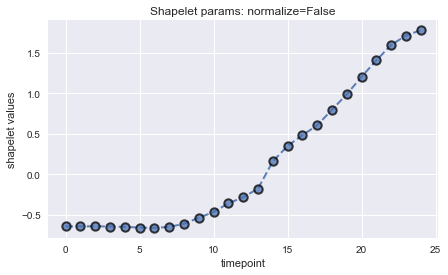

In [51]:
from aeon.visualisation import ShapeletVisualizer

shp_vis = ShapeletVisualizer(S)
fig = shp_vis.plot(figure_options={"figsize": (7, 4)})

Historicaly, shapelets were first proposed as a primitive for time series machine learning [[1]](https://www.cs.ucr.edu/~eamonn/shaplet.pdf) and were used as spliting criterion in a decision tree for time series classification. To make this work a distance $dist$ between a shapelet $S$ and a time series $X$ was defined such as $dist(S,X) \rightarrow \mathbb{R}$. The Shapelet-based splitting criterion was then based on a threshold $\lambda$ on the distance as $dist(S,X) < \lambda$ to direct time series $X$ to the left or right child node, with each node being defined by another shapelet.

This way of calculating this distance, which is still used today, was to compute the euclidean distance between $S$ and all subsequence of size $l$ in $X$, and to return the minimum. More formally :

$\displaystyle{dist(S,X) = \min\limits_{i\ :1, \ldots, m-l+1} \sqrt{\sum_{j=0}^{l-1}(\mathbf{s}_j - \mathbf{x}_i+j)^2}}$

This represent the idea that the distance of a shapelet to a time series is the distance between the shapelet and the better matching subsequence of the same size in $X$.

We can visualize this idea in two ways, first, we can position the shapelet on its best-matching subsequence in a time series $X$ :


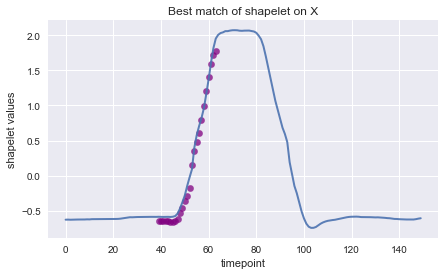

In [47]:
fig = shp_vis.plot_on_X(X_test[1], figure_options={"figsize": (7, 4)})

Or we can visualize the distance between the shapelet $S$ and all subsequences the same size in $X$. We refer to this as the **distance vector** between $S$ and $X$, and its defined as 

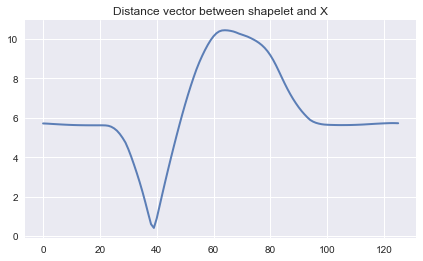

In [48]:
fig = shp_vis.plot_distance_vector(X_test[1], figure_options={"figsize": (7, 4)})

## 1.3 From Shapelet trees to the Shapelet Transform

A bit later the Shapelet Transform [[2]](https://ueaeprints.uea.ac.uk/id/eprint/40201/1/LinesKDD2012.pdf) was introduced as an alternative to shapelet-based decision trees. Their idea was to use shapelets not as a splitting criterion in a tree, but as a way to extract features from time series, in order to be able to use any kind of tabular classifier. In this method, only one feature was extracted from each time series $X$ and each shapelet $S$ : the distance $dist(S,X)$.

Given a set of $k$ shapelet ${\cal S} = [S_1, \ldots, S_k]$, this allows to create an embedding ${\cal X}'$ of a time series dataset ${\cal X} = [X_1, \ldots, X_n]$ such as :

$\displaystyle{{\cal X}' = \begin{bmatrix}
dist(S_1, X_1) & ... & dist(S_k, X_1) \\
... & ... & ... \\
dist(S_1, X_n) & ... & dist(S_k, X_n) 
\end{bmatrix}}$

Which can be used as a tabular dataset with $k$ features by any tabular classifier. In aeon, every shapelet-based transformation algorithm is following this same reasoning, with some extracting more than one feature per shapelet (for example [RDST](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.transformations.collection.shapelet_based.RandomDilatedShapeletTransform.html), which extract 3 features, giving $3k$ features). 

We can list all the available shapelet transformer in aeon by doing the following :




In [16]:
from aeon.registry import all_estimators

for k, v in all_estimators("transformer", filter_tags={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>


Let us for example select the `RandomShapeletTransform` transformer, we can use the `fit` and `transform` functions to obtain the time series embdeding :

In [18]:
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

st = RandomShapeletTransform(max_shapelets=10).fit(X_train, y_train)
st.transform(X_test).shape

(150, 10)

As planned, we obtain a matrix of size $(n,k)$ ! Given a fitted instance of any shapelet-based transformations, we can use another visualization class to plot the shapelets that were extracted :

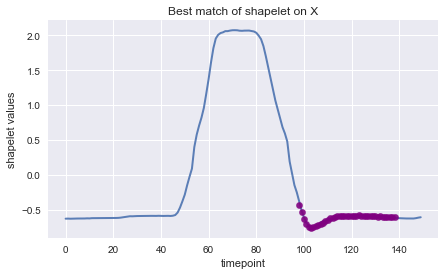

In [49]:
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform
from aeon.visualisation import ShapeletTransformerVisualizer

st = RandomShapeletTransform(max_shapelets=10).fit(X_train, y_train)
st_vis = ShapeletTransformerVisualizer(st)
id_shapelet = 0  # Identifier of the shapelet

fig = st_vis.plot_on_X(id_shapelet, X_test[1], figure_options={"figsize": (7, 4)})

You can also create and customize your own shapelet plots with this class, for example :


Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

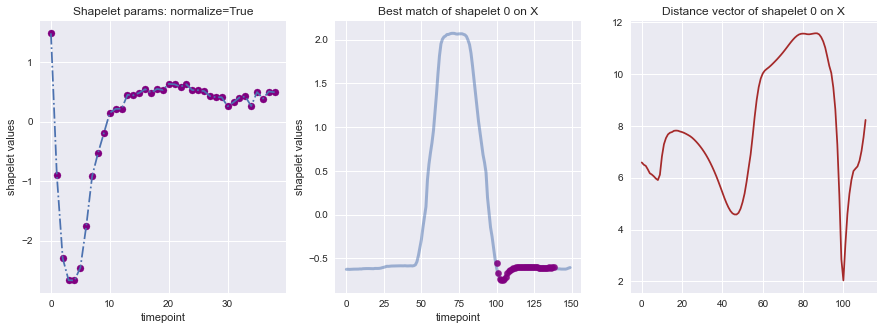

In [40]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
st_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
st_vis.plot_on_X(
    id_shapelet, X_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
st_vis.plot_distance_vector(
    id_shapelet, X_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

## 1.4 Normalized shapelets

Notice in the above plot that the shapelet values do not match the ones used to position it on the time series. This is due to the fact that in `RandomShapeletTransform`, all shapelets use a normalized distance. This have the effect of making the shapelet **scale-invariant**. This mean that the best match to the shapelet will now be a subsequence of the shape **shape** independently of its **scale**.


To achieve this, both the shapelet values and the subsequences values are z-normalized prior to computing $dist(S,X)$, for example to z-normalize $S$, we first compute $\mu_S$ and $\sigma_S$, respectively the mean and standard deviation of $S$ and obtain its normalized version $\bar{S}$ as :

$\displaystyle{\bar{S} = \frac{(S - \mu_S)}{\sigma_S}}$


## 1.5 How are shapelet extracted from the time series ?

Now that we understand what shapelets are and how they are used, a question is left unanswered, how do we extract them ? This process is hidden behind the `fit` method of the shapelet-based transformations. We can distinguish x type of shapelet extraction process:

WIP From here

- Heuristic-based extraction:
- Brute force extraction:
- Shapelet generation:


Finding shapelets involves selecting and evaluating shapelets. The original shapelet
tree and STC performed a full enumeration of all possible shapelets before keeping
the best ones. This is computationally inefficient and can lead to over fitting.
More recent shapelet based machine learning algorithms randomise the search.

In [1]:
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from aeon.datasets import load_basic_motions
from aeon.registry import all_estimators
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

warnings.filterwarnings("ignore")
all_estimators("classifier", filter_tags={"algorithm_type": "shapelet"})

[('MrSQMClassifier',
  aeon.classification.shapelet_based._mrsqm.MrSQMClassifier),
 ('RDSTClassifier', aeon.classification.shapelet_based._rdst.RDSTClassifier),
 ('ShapeletTransformClassifier',
  aeon.classification.shapelet_based._stc.ShapeletTransformClassifier)]

### Shapelet Transform for Classification

The `RandomShapeletTransform` transformer takes a set of labelled training time series in the `fit` function, randomly samples `n_shapelet_samples`  shapelets, keeping the best  `max_shapelets`. The resulting shapelets are used in the `transform` function to create a new tabular dataset, where each row represents a time series instance, and each column stores the distance from a time series to a shapelet. The resulting tabular data can be used by any scikit learn compatible classifier. In this notebook we will explain these terms and describe how the algorithm works. But first we show it in action. We will use the BasicMotions data as an example. This data set contains time series of motion traces for the activities "running", "walking", "standing" and "badminton". The learning problem is to predict the activity given the time series. Each time series has six channels: x, y, z position and x, y, z accelerometer of the wrist. Data was recorded on a smart watch.

In [2]:
X, y = load_basic_motions(split="train")
rst = RandomShapeletTransform(n_shapelet_samples=100, max_shapelets=10, random_state=42)
st = rst.fit_transform(X, y)
print(" Shape of transformed data = ", st.shape)
print(" Distance of second series to third shapelet = ", st[1][2])
testX, testy = load_basic_motions(split="test")
tr_test = rst.transform(testX)
rf = RandomForestClassifier(random_state=10)
rf.fit(st, y)
preds = rf.predict(tr_test)
print(" Shapelets + random forest acc = ", accuracy_score(preds, testy))

 Shape of transformed data =  (40, 8)
 Distance of second series to third shapelet =  1.302772121165026
 Shapelets + random forest acc =  0.95


### Visualising Shapelets
The first column of the transformed data represents the distance from the first shapelet to each time series. The shapelets are sorted, so the first shapelet is the one we estimate is the best (using the calculation described below). You can recover the shapelets from the transform. Each shapelet is a 7-tuple, storing the following information:

In [3]:
running_shapelet = rst.shapelets[0]
print("Quality = ", running_shapelet[0])
print("Length = ", running_shapelet[1])
print("position = ", running_shapelet[2])
print("Channel = ", running_shapelet[3])
print("Origin Instance Index = ", running_shapelet[4])
print("Class label = ", running_shapelet[5])
print("Shapelet = ", running_shapelet[6])

Quality =  0.81127812
Length =  39
position =  55
Channel =  0
Origin Instance Index =  11
Class label =  running
Shapelet =  [-0.85667017 -1.88711152 -0.8751295   0.80633757  1.10838333  0.69810992
  0.85713394  1.23190921  0.01801365 -1.29683966 -1.94694259 -0.37487726
 -0.37487726  1.39471462  0.74922685  0.74922685  0.22343376  0.22343376
 -0.7730703  -1.37591995 -0.80376393  1.32758071  0.99778845  0.6013481
  0.83711118  0.93684593  0.93684593 -1.30429475 -1.64522057 -0.56312308
  0.96855713  0.56796251  0.35714242  0.62066541  0.65135287 -0.80531237
 -1.49170075 -1.18512797  0.69685753]


We can directly extract shapelets and inspect them. These are the the two shapelets that are best at discriminating badminton and running against other activities. All shapelets are normalised to provide scale invariance.

## Performance on the UCR univariate datasets

Our current shapelet classifiers are in the directory aeon.classification
.shapelet_based. We currently only have reference results for three of these.

In [6]:
all_shapelet_classifiers = [
    "MrSQMClassifier",
    "ShapeletTransformClassifier",
    "RDSTClassifier",
    "SASTClassifier",
    "RSASTClassifier",
    "LearningShapeletClassifier",
]
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

est = ["MrSQMClassifier", "RDSTClassifier", "ShapeletTransformClassifier"]
names = [t.replace("Classifier", "") for t in est]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 3)

(<Figure size 600x220 with 1 Axes>, <Axes: >)

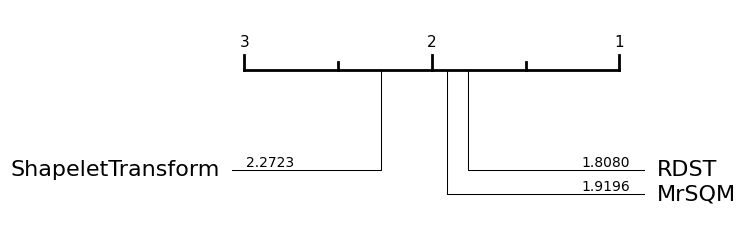

In [7]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

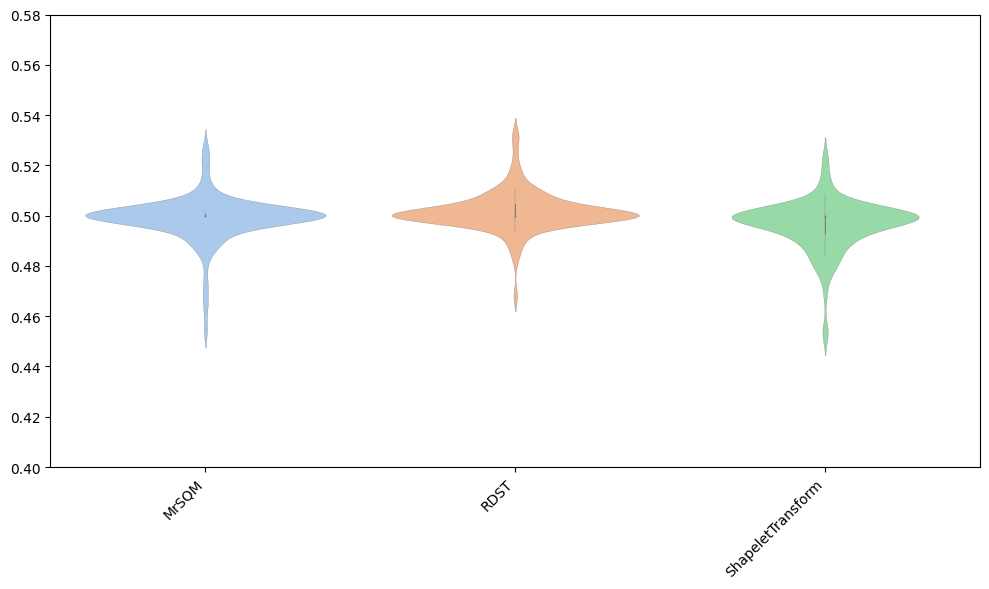

In [8]:
plot_boxplot_median(results, names)

## References

[1] L. Ye and E. Keogh. Time series shapelets: A new primitive for data mining. In Proc. 15th ACM SIGKDD, 2009
[2] J. Lines et al. A shapelet transform for time series classification. In Proc. 18th ACM SIGKDD, 2012.
